In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Layer, MultiHeadAttention
from tensorflow.keras.layers import Bidirectional, Dropout
from tensorflow.keras.layers import Masking, Input, Lambda
import tensorflow_probability as tfp
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
from numpy.fft import fft
from scipy.stats import skew, kurtosis 
import pandas as pd
import glob
import matplotlib.pyplot as plt
import os
import struct
import glob
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, accuracy_score


import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import struct
from numpy.fft import fft
from scipy.stats import skew, kurtosis
import torch
from torch import nn
from torch.nn import functional as F

# Check if CUDA is available and set the device to GPU if it is, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class ComplexNumbersDataset(Dataset):
    def __init__(self, filepath, sequence_length, max_samples=None, for_training=True, process_method='data1'):
        self.filepath = filepath
        self.sequence_length = sequence_length
        self.max_samples = max_samples
        self.for_training = for_training
        self.process_method = process_method
        self.samples = self.load_samples()
        self.samples_per_sequence = self.sequence_length
        #self.samples_per_sequence = self.sequence_length if for_training else 1

    def load_samples(self):
        samples = []
        with open(self.filepath, 'rb') as binary_file:
            while True:
                if self.max_samples and len(samples) >= self.max_samples:
                    break
                binary_data = binary_file.read(8)
                if not binary_data:
                    break
                decoded_data = struct.unpack('ff', binary_data)
                if decoded_data[0] == 0 and decoded_data[1] == 0:
                    continue
                samples.append(f"{decoded_data[0]}+{decoded_data[1]}j")
        return samples

    def process_data1(self, sequence_samples):
        #print('sequence_samples:', sequence_samples)
        #print('len(sequence_samples):', len(sequence_samples))
        real_parts = []
        imag_parts = []
        for sample in sequence_samples:
            # Remove potential unwanted characters (spaces, etc.)
            sample = sample.replace(" ", "").replace("+-", "-")
            try:
                c = complex(sample)
                real_parts.append(c.real)
                imag_parts.append(c.imag)
            except ValueError:
                print(f"Failed to convert: {sample}")  # This will show which string failed
                raise
        real_parts = np.array(real_parts)
        imag_parts = np.array(imag_parts)
        # Normalize
        real_parts = (real_parts - np.mean(real_parts)) / np.std(real_parts)
        imag_parts = (imag_parts - np.mean(imag_parts)) / np.std(imag_parts)

        # Combining real and imaginary parts
        X = np.stack((real_parts, imag_parts), axis=1)  # Shape: (sequence_length, 2)
        return torch.tensor(X, dtype=torch.float32)

    def process_data2(self, sequence_samples):
        samples_array = np.array([complex(sample) for sample in sequence_samples], dtype=np.complex64)
        samples_fft = fft(samples_array)
        real_parts = np.real(samples_fft)
        imag_parts = np.imag(samples_fft)
        
        # Normalization
        epsilon = 1e-10
        real_parts_normalized = (real_parts - np.mean(real_parts)) / (np.std(real_parts) + epsilon)
        imag_parts_normalized = (imag_parts - np.mean(imag_parts)) / (np.std(imag_parts) + epsilon)
        
        # Feature extraction
        features = np.column_stack((
            np.mean(real_parts_normalized), np.std(real_parts_normalized), skew(real_parts_normalized),
            kurtosis(real_parts_normalized), np.mean(imag_parts_normalized), np.std(imag_parts_normalized),
            skew(imag_parts_normalized), kurtosis(imag_parts_normalized)
        ))
        
        return torch.tensor(features, dtype=torch.float32).reshape(self.samples_per_sequence, -1)

    def __len__(self):
        return len(self.samples) // self.samples_per_sequence

    def __getitem__(self, idx):
        start_idx = idx * self.samples_per_sequence
        end_idx = start_idx + self.samples_per_sequence
        sequence_samples = self.samples[start_idx:end_idx]
        
        if self.process_method == 'data1':
            X = self.process_data1(sequence_samples)
        elif self.process_method == 'data2':
            X = self.process_data2(sequence_samples)
        else:
            raise ValueError("Invalid process method specified.")
        if self.for_training:
            return X, X
        else:
            return X
#------------------------------------------------------------------------------------------------------
def mec_kocaoglu_np(p, q, device):
    """
    Compute the joint distribution matrix with minimal entropy between two given distributions in PyTorch.
    """
    p = p.float() / p.sum()
    q = q.float() / q.sum()
    J = torch.zeros(q.size(0), p.size(0), dtype=torch.float64, device=device)
    M = torch.stack([p, q], dim=0)
    r = torch.min(torch.max(M, dim=1).values)

    while r > 0:
        a_i = torch.argmax(M, dim=1)
        r_updated = torch.min(torch.max(M, dim=1).values)
        update_values = torch.stack([r, r])
        for i, index in enumerate(a_i):
            M[i, index] -= update_values[i]
            J[index, i] += update_values[i]
        r = r_updated

    return J
def apply_mec_to_data(data, device, num_bins=10, latent_dim=50):
    """
    Apply the MEC transformation to each sample in the data.
    """
    def process_sample(sample):
        # Find the min and max values in the sample and convert them to Python scalars
        min_val = torch.min(sample).item()
        max_val = torch.max(sample).item()
        
        # Now min_val and max_val are Python numbers, suitable for torch.histc()
        sample_histogram = torch.histc(sample, bins=num_bins, min=min_val, max=max_val)
        sample_histogram = sample_histogram.float() / sample_histogram.sum()

        mec_transformed = mec_kocaoglu_np(sample_histogram, sample_histogram, device)

        # Flatten the 2D to 1D and adjust to match the latent_dim
        transformed_sample = mec_transformed.flatten()
        if transformed_sample.size(0) > latent_dim:
            transformed_sample = transformed_sample[:latent_dim]
        else:
            padding = torch.zeros(latent_dim - transformed_sample.size(0), dtype=torch.float64)
            transformed_sample = torch.cat([transformed_sample, padding], dim=0)

        return transformed_sample

    # Process each sample in the batch
    transformed_batch = torch.stack([process_sample(sample) for sample in data])
    transformed_batch = transformed_batch.float() 

    return transformed_batch

def process_latent_variables(z, device):
    """
    Transform latent variables using MEC.
    """
    # Assuming 'z' is a batch of latent variables
    z_transformed = apply_mec_to_data(z, device=device)
    return z_transformed

#self Attention LSTM Autoencoder Model
class SelfAttentionLayer(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(SelfAttentionLayer, self).__init__()
        self.multihead_attention = nn.MultiheadAttention(embed_dim=embed_size, num_heads=num_heads)

    def forward(self, inputs):
        # PyTorch's MultiheadAttention expects inputs of shape (sequence_length, batch_size, embed_size)
        inputs = inputs.permute(1, 0, 2)
        attn_output, _ = self.multihead_attention(inputs, inputs, inputs)
        return attn_output.permute(1, 0, 2)  # Return to original shape (batch_size, sequence_length, embed_size)

# Variational Autoencoder (VAE) Class

class Encoder(nn.Module):
    def __init__(self, sequence_length, feature_dim, intermediate_dim, latent_dim, epsilon_std=0.1):
        super(Encoder, self).__init__()
        self.lstm1 = nn.LSTM(input_size=feature_dim, hidden_size=intermediate_dim, batch_first=True)
        self.self_attention = SelfAttentionLayer(embed_size=intermediate_dim, num_heads=2)  # Ensure compatibility
        #self.self_attention = SelfAttentionLayer(num_heads=2, key_dim=intermediate_dim)
        self.lstm2 = nn.LSTM(input_size=intermediate_dim, hidden_size=50, batch_first=True)
        self.z_mean = nn.Linear(in_features=50, out_features=latent_dim)
        self.z_log_var = nn.Linear(in_features=50, out_features=latent_dim)
        self.epsilon_std = epsilon_std

    def _sampling3(self, z_mean, device):
        # Assuming process_latent_variables(z) is adapted for PyTorch
        z_mean = z_mean.to(device)
        z_mean_transformed = process_latent_variables(z_mean, device)
        eps = torch.randn_like(z_mean_transformed) * self.epsilon_std
        return z_mean_transformed
    
    def _sampling(self, z_mean, z_log_var):
        # Standard sampling function, kept for compatibility
        std = torch.exp(0.5 * z_log_var)
        eps = torch.randn_like(std)
        return z_mean + eps * std

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.self_attention(x)
        x, (h_n, _) = self.lstm2(x)
        z_mean = self.z_mean(h_n[-1])
        z_log_var = self.z_log_var(h_n[-1])
        z = self._sampling3(z_mean, device)  # Use _sampling3/sampling
        return z, z_mean, z_log_var
    
class Decoder(nn.Module):
    def __init__(self, sequence_length, feature_dim, latent_dim):
        super(Decoder, self).__init__()
        self.sequence_length = sequence_length
        self.lstm1 = nn.LSTM(input_size=latent_dim, hidden_size=50, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=50, hidden_size=100, batch_first=True)
        self.output_layer = nn.Linear(in_features=100, out_features=feature_dim)

    def forward(self, z):
        # Repeat 'z' for 'sequence_length' times
        # Assuming 'z' shape is [batch_size, latent_dim], we first unsqueeze it to add a sequence length dimension
        # Then repeat across this dimension
        z = z.unsqueeze(1).repeat(1, self.sequence_length, 1)
        
        # Now 'z' shape is [batch_size, sequence_length, latent_dim], suitable for LSTM input
        z, _ = self.lstm1(z)
        z, _ = self.lstm2(z)
        return torch.sigmoid(self.output_layer(z))

class VAE(nn.Module):
    def __init__(self, sequence_length, feature_dim, intermediate_dim, latent_dim, epsilon_std=0.1):
        super(VAE, self).__init__()
        self.encoder = Encoder(sequence_length, feature_dim, intermediate_dim, latent_dim, epsilon_std)
        self.decoder = Decoder(sequence_length, feature_dim, latent_dim)

    def forward(self, x):
        x = x.to(device)
        z, z_mean, z_log_var = self.encoder(x)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, z_mean, z_log_var

def vae_loss(reconstructed_x, x, z_mean, z_log_var):
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
    return reconstruction_loss + kl_divergence


# Instantiate and Compile the VAE
import torch
from torch import optim

# Instantiate the VAE
sequence_length = 10
feature_dim = 2
intermediate_dim = 100
latent_dim = 50
epsilon_std = 0.1

#vae_model = VAE(sequence_length, feature_dim, intermediate_dim, latent_dim, epsilon_std)
vae_model = VAE(sequence_length, feature_dim, intermediate_dim, latent_dim, epsilon_std).to(device)

optimizer = optim.Adam(vae_model.parameters(), lr=0.005)
loss_function = nn.MSELoss()

# Model Training
batch_size = 100
max_train_samples = 4000000
train_steps = max_train_samples // (batch_size * sequence_length)
max_samples = 4000000  # Maximum samples to read (or None to read all)
max_test_samples = 4000000

pure_file_pattern = '/home/mreza/5G accelerator/ID_MEC/data generator/pure_data/pure_iq_samples_*.csv'
mixed_file_pattern = '/home/mreza/5G accelerator/ID_MEC/data generator/mixed_data/mixed_iq_samples_*.csv'
pure_file_new = '/home/mreza/5G accelerator/ID_MEC/data generator/New Data-Collection/rx_IQ_pure'
mixed_file_new = '/home/mreza/5G accelerator/ID_MEC/data generator/New Data-Collection/rx_IQ_MIX'
pure_file_old = '/home/mreza/5G accelerator/IQ_samples/data collected/5G_DL_IQ_no_jamming_0924.dat'
mixed_file_old = '/home/mreza/5G accelerator/IQ_samples/data collected/5G_DL_IQ_with_periodic_jamming_0928_02.dat'

# Creating dataset instances for training and validation/testing
train_gen_instance  = ComplexNumbersDataset(filepath=pure_file_new, 
                                            sequence_length=sequence_length, 
                                            max_samples=max_train_samples, for_training=True, 
                                            process_method='data1')

combined_gen_instance = ComplexNumbersDataset(filepath=mixed_file_new, 
                                              sequence_length=sequence_length, 
                                              max_samples=max_samples, for_training=False, 
                                              process_method='data1')

# Creating DataLoader instances for batching
# Setting up DataLoader instances
train_loader = DataLoader(train_gen_instance, batch_size=batch_size, shuffle=False, drop_last=True)
combined_loader = DataLoader(combined_gen_instance, batch_size=batch_size, shuffle=False, drop_last=True)

# Custom training loop in PyTorch
num_epochs = 2
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    vae_model.train()  # Set the model to training mode

    total_loss = 0
    for batch_idx, (X_chunk, _) in enumerate(train_loader):  # Assuming autoencoder where input = target
        X_chunk = X_chunk.to(device)
        
        optimizer.zero_grad()
        reconstructed_x, _, _ = vae_model(X_chunk)
        loss = loss_function(reconstructed_x, X_chunk)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item()}")

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Average Loss: {avg_loss}\n")


num_predictions = 200  # or any other large number
print(f"Number of predictions to be performed: {num_predictions}")
reconstruction_errors = []
all_X_chunk_test = []
all_X_chunk_pred = []
all_intrusion_flags = []
vae_model.eval()  # Set the model to evaluation mode


vae_model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for batch_idx, X_chunk_test in enumerate(combined_loader):
        X_chunk_test = X_chunk_test.to(device)
        X_chunk_pred, _, _ = vae_model(X_chunk_test)
        
        chunk_errors = torch.mean((X_chunk_test - X_chunk_pred) ** 2, dim=1)
        reconstruction_errors.extend(chunk_errors.cpu().numpy())
        all_X_chunk_test.append(X_chunk_test)
        all_X_chunk_pred.append(X_chunk_pred)

        if batch_idx % 100 == 0:
            print(f"Evaluating Batch {batch_idx}/{len(combined_loader)}")

reconstruction_error = np.array(reconstruction_errors)
print(f"Completed predictions. Total number of batches: {len(combined_loader)}")

reconstruction_error = np.array(reconstruction_errors)
# Further processing...



#reconstruction_error = np.array(reconstruction_errors)
print('reconstruction_error.shape:', reconstruction_error.shape)
print('Number of NaNs in reconstruction_error:', np.isnan(reconstruction_error).sum())
max_error_per_sequence = reconstruction_error.max(axis=1) # Max error for each sequence
#print('max_error_per_sequence:', max_error_per_sequence)

print('max_error_per_sequence.shape:', max_error_per_sequence.shape)

threshold1 = np.percentile(max_error_per_sequence, 98)
print('threshold1:', threshold1)
threshold2 = np.percentile(reconstruction_error, 95)
print('threshold percentile:', threshold2)

is_intrusion_detected = max_error_per_sequence > threshold1  # Boolean array for sequences
print('len(is_intrusion_detected):', len(is_intrusion_detected))
print('is_intrusion_detected.shape:', is_intrusion_detected.shape)

#is_intrusion_detected2 = error_per_sequence > threshold1

num_total_sequences = len(max_error_per_sequence)
num_total_sequences2 = num_predictions * batch_size - num_predictions
print('num_total_sequences:', num_total_sequences)
print('num_total_sequences2:', num_total_sequences2)

#---------------------------------------finish 111-----------------------------------
flat_error_per_sequence = max_error_per_sequence.flatten()
#flat_error_per_sequence2 = error_per_sequence.flatten()
# Determine if intrusion detected for each sequence
for error in flat_error_per_sequence:
    all_intrusion_flags.append(error > threshold1)
all_X_chunk_test = [x.cpu() for x in all_X_chunk_test]
all_X_chunk_pred = [x.cpu() for x in all_X_chunk_pred]

all_X_chunk_test = np.concatenate(all_X_chunk_test, axis=0)
all_X_chunk_pred = np.concatenate(all_X_chunk_pred, axis=0)

#save_path = 'C:\\Users\\Mohammadreza\\Desktop\\My Class\\Proj-DC\\My Works\\My Papers\\intrusion\\data generator\\intrusion_detected'
#plot_with_intrusions8(all_X_chunk_test, all_X_chunk_pred, all_intrusion_flags, sequence_length, save_path)

jamming_detected = reconstruction_error > threshold1
#train_gen_instance.close()
#combined_gen_instance.close()
#Table
flattened_jamming_detected = jamming_detected.flatten()
real_part_detected = jamming_detected[:, 0]
imag_part_detected = jamming_detected[:, 1]

real_true_count = np.sum(real_part_detected)
real_false_count = len(real_part_detected) - real_true_count

imag_true_count = np.sum(imag_part_detected)
imag_false_count = len(imag_part_detected) - imag_true_count
# Overall
overall_true_count = np.sum(flattened_jamming_detected)
overall_false_count = len(flattened_jamming_detected) - overall_true_count
# Table-DataFrame
df = pd.DataFrame({
    'Part': ['Real', 'Imaginary', 'Overall'],
    'True Count': [real_true_count, imag_true_count, overall_true_count],
    'False Count': [real_false_count, imag_false_count, overall_false_count]
})
print(df)
num_jamming_detected = np.sum(jamming_detected)
print(f"Number of jamming sequences detected: {num_jamming_detected} out of {len(flattened_jamming_detected)} sequences")




2024-04-12 14:42:06.098597: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-12 14:42:06.099628: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 14:42:06.123974: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 14:42:06.124498: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 14:42:06.528800: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Using device: cpu
Epoch 1/2
Batch 0/4000, Loss: 1.2387577295303345
Batch 100/4000, Loss: 0.9999719262123108
Batch 200/4000, Loss: 0.9998762011528015
Batch 300/4000, Loss: 1.0002082586288452
Batch 400/4000, Loss: 1.0001379251480103
Batch 500/4000, Loss: 0.9999024868011475
Batch 600/4000, Loss: 1.0000783205032349
Batch 700/4000, Loss: 0.9999758005142212
Batch 800/4000, Loss: 1.0000008344650269
Batch 900/4000, Loss: 0.9998245239257812
Batch 1000/4000, Loss: 0.9995427131652832
Batch 1100/4000, Loss: 0.9999949932098389
Batch 1200/4000, Loss: 0.9999925494194031
Batch 1300/4000, Loss: 0.9999699592590332
Batch 1400/4000, Loss: 1.000000238418579
Batch 1500/4000, Loss: 0.9999997615814209
Batch 1600/4000, Loss: 1.0
Batch 1700/4000, Loss: 1.0
Batch 1800/4000, Loss: 0.9999999403953552
Batch 1900/4000, Loss: 0.9999992847442627
Batch 2000/4000, Loss: 1.0000001192092896
Batch 2100/4000, Loss: 1.0000004768371582
Batch 2200/4000, Loss: 0.9999997615814209
Batch 2300/4000, Loss: 0.9999993443489075
Batch 2

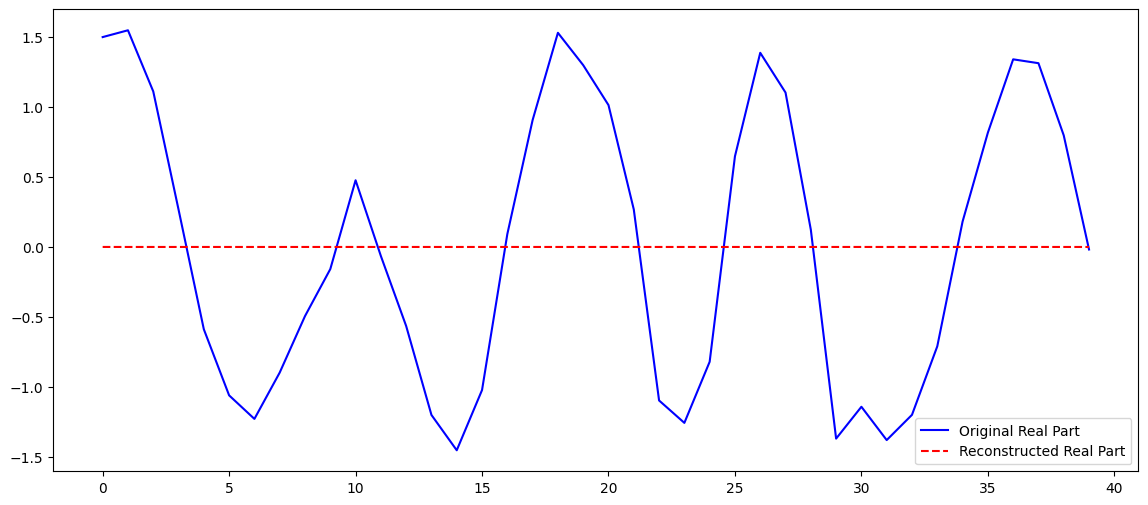

In [2]:
n = 4
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
# Ensure n sequences are available
n = min(n, len(X_chunk_test) - sequence_index)

# Convert PyTorch tensors to numpy arrays
original_sample_np = X_chunk_test[sequence_index:sequence_index + n].detach().cpu().numpy()
reconstructed_sample_np = X_chunk_pred[sequence_index:sequence_index + n].detach().cpu().numpy()

# Since your data is 3-dimensional (batch, sequence, features), you'll want to concatenate along the sequence axis (axis=1)
original_sample_concat = np.concatenate(original_sample_np, axis=0)
reconstructed_sample_concat = np.concatenate(reconstructed_sample_np, axis=0)

# Plot concatenated sequences
plt.figure(figsize=(14, 6))
plt.plot(original_sample_concat[:, 0], 'b-', label='Original Real Part')  # Assuming first feature is the real part
plt.plot(reconstructed_sample_concat[:, 0], 'r--', label='Reconstructed Real Part')  # Assuming first feature is the real part
plt.legend()
plt.show()


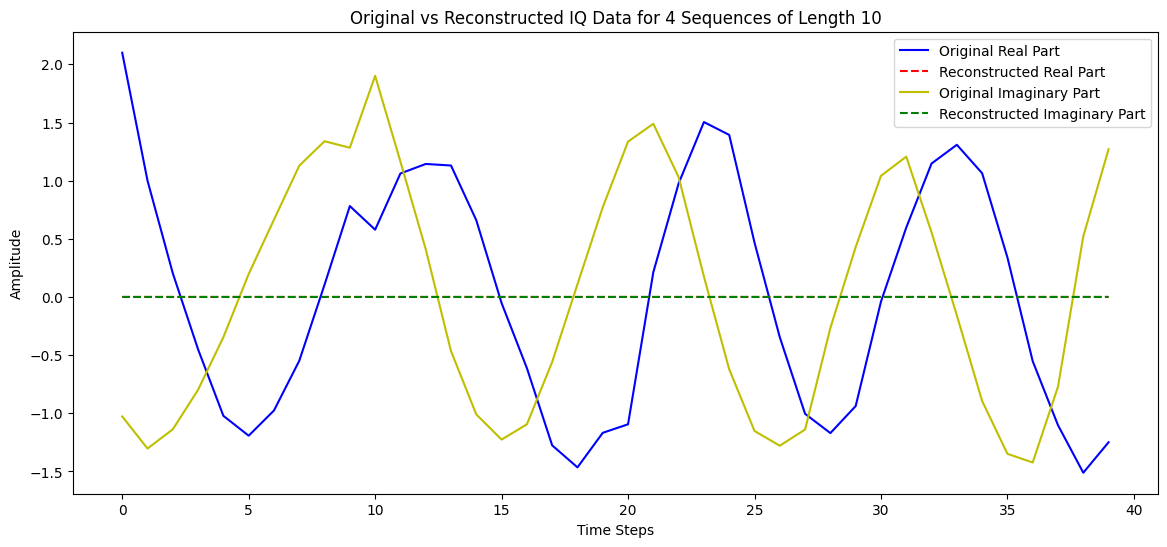

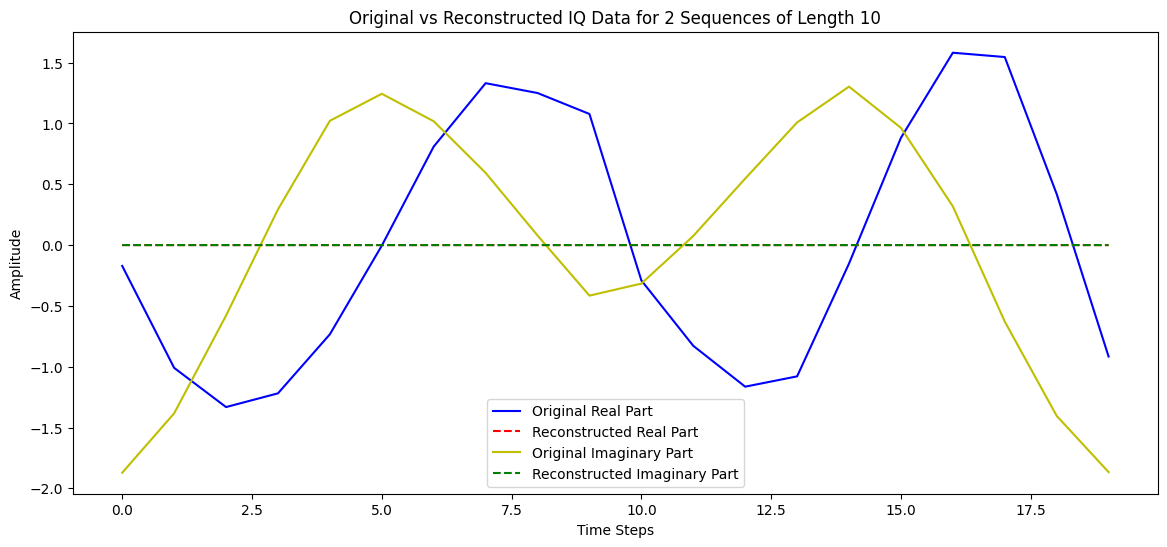

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of sequences to plot together
n = 4  # Change this to desired number of sequences

# Ensure that we have enough samples for the desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)

# Convert PyTorch tensors to numpy arrays and concatenate selected sequences
original_sample_concat = np.concatenate(X_chunk_test[sequence_index:sequence_index + n].cpu().numpy(), axis=0)
reconstructed_sample_concat = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n].cpu().numpy(), axis=0)

# Plot concatenated sequences for n = 4
plt.figure(figsize=(14, 6))
plt.plot(original_sample_concat[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample_concat[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample_concat[:, 1], 'y-', label='Original Imaginary Part')
plt.plot(reconstructed_sample_concat[:, 1], 'g--', label='Reconstructed Imaginary Part')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Repeat for n = 2
n = 2  # Change this to a different desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample_concat = np.concatenate(X_chunk_test[sequence_index:sequence_index + n].cpu().numpy(), axis=0)
reconstructed_sample_concat = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n].cpu().numpy(), axis=0)

# Plot concatenated sequences for n = 2
plt.figure(figsize=(14, 6))
plt.plot(original_sample_concat[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample_concat[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample_concat[:, 1], 'y-', label='Original Imaginary Part')
plt.plot(reconstructed_sample_concat[:, 1], 'g--', label='Reconstructed Imaginary Part')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


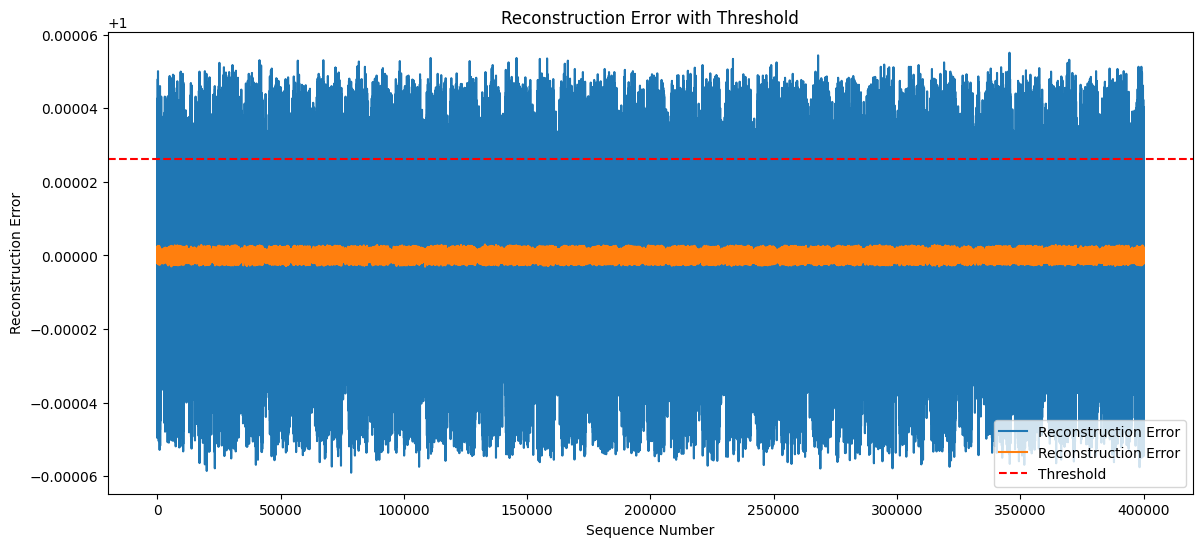

In [4]:

# reconstruction error
plt.figure(figsize=(14, 6))
plt.plot(reconstruction_error, label='Reconstruction Error')
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error with Threshold')
plt.xlabel('Sequence Number')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('1-Reconstruction Error with Threshold.png')
# plt.close()
plt.show()

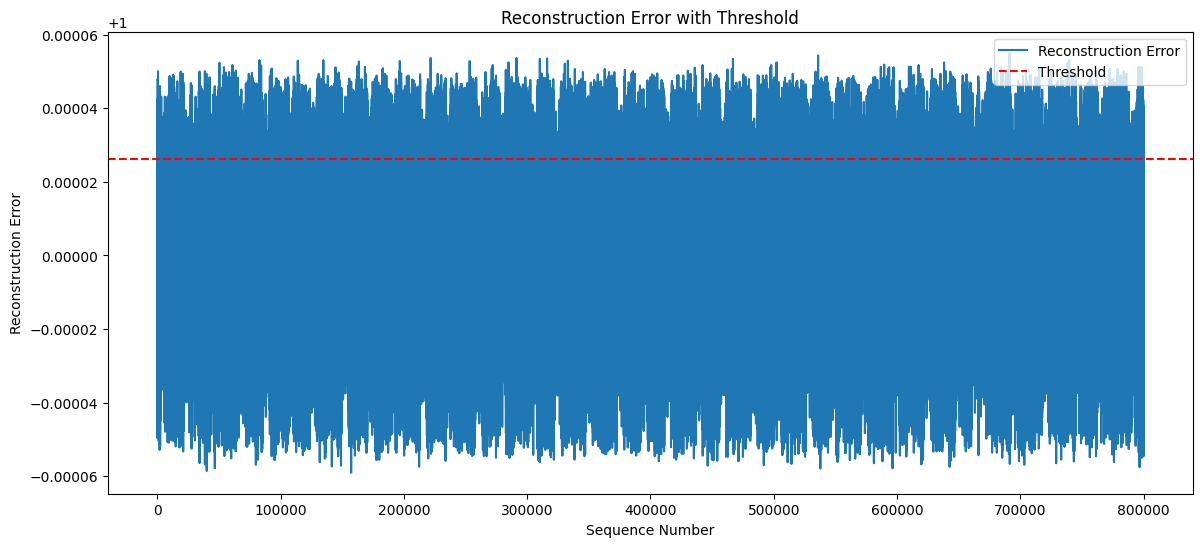

In [5]:
# Flatten the reconstruction_error to 1D
reconstruction_error_flat = reconstruction_error.flatten()
# reconstruction error
plt.figure(figsize=(14, 6))
plt.plot(reconstruction_error_flat, label='Reconstruction Error')
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error with Threshold')
plt.xlabel('Sequence Number')
plt.ylabel('Reconstruction Error')
plt.legend()
# plt.savefig('1-Reconstruction Error with Threshold.png')
# plt.close()
plt.show()


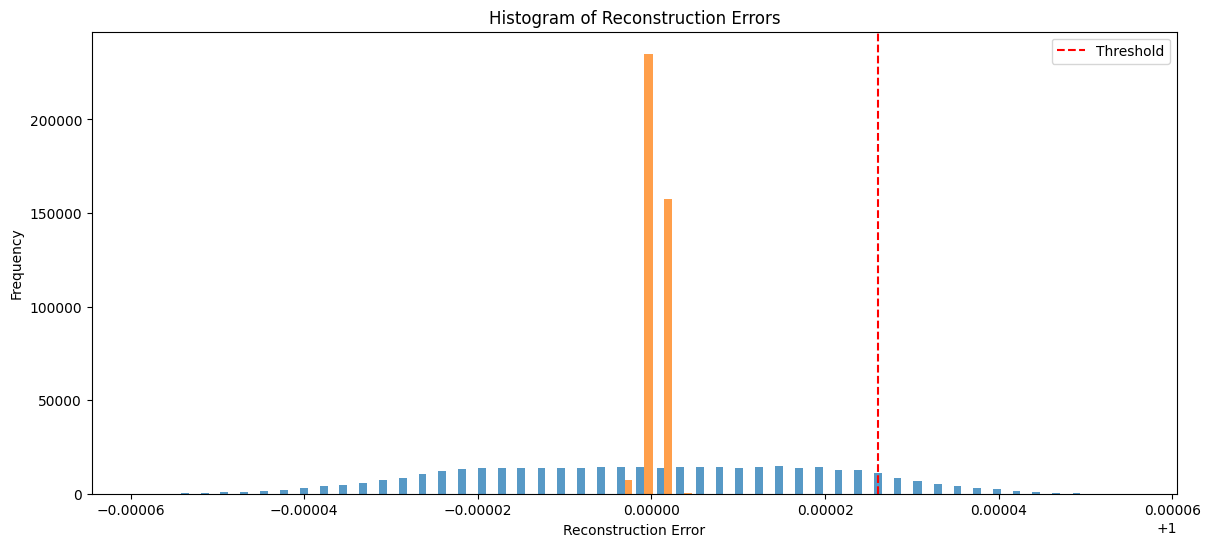

In [6]:
#Histogram of Reconstruction Errors:
plt.figure(figsize=(14, 6))
plt.hist(reconstruction_error, bins=50, alpha=0.75)
plt.axvline(x=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
# plt.savefig('4-Histogram of Reconstruction Errors.png')
# plt.close()
plt.show()


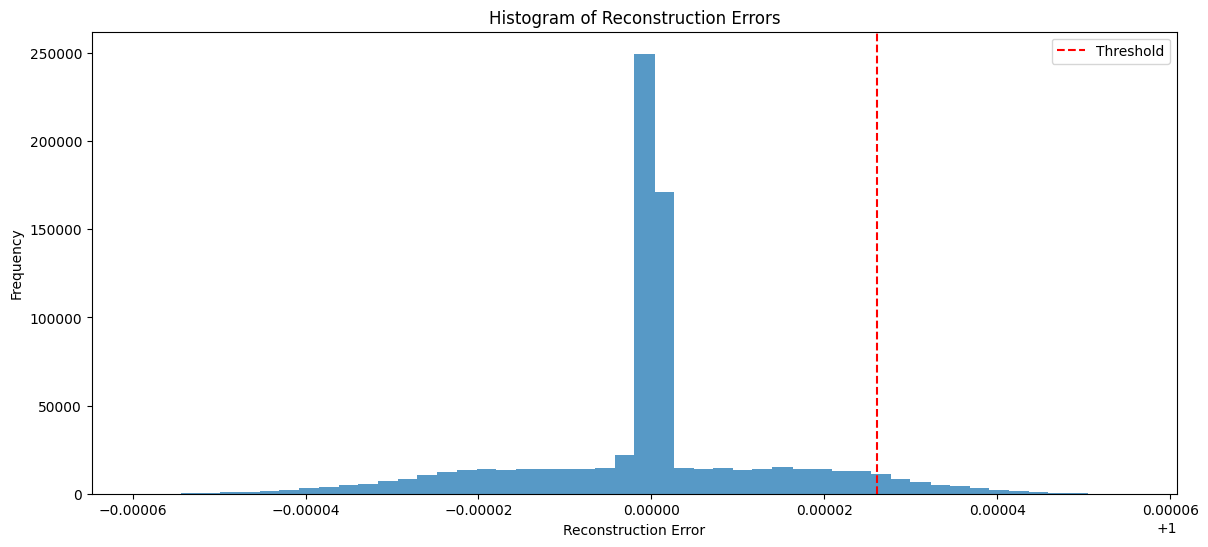

In [7]:
# Flatten the reconstruction_error to 1D
reconstruction_error_flat = reconstruction_error.flatten()
#Histogram of Reconstruction Errors:
plt.figure(figsize=(14, 6))
plt.hist(reconstruction_error_flat, bins=50, alpha=0.75)
plt.axvline(x=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
# plt.savefig('4-Histogram of Reconstruction Errors.png')
# plt.close()
plt.show()

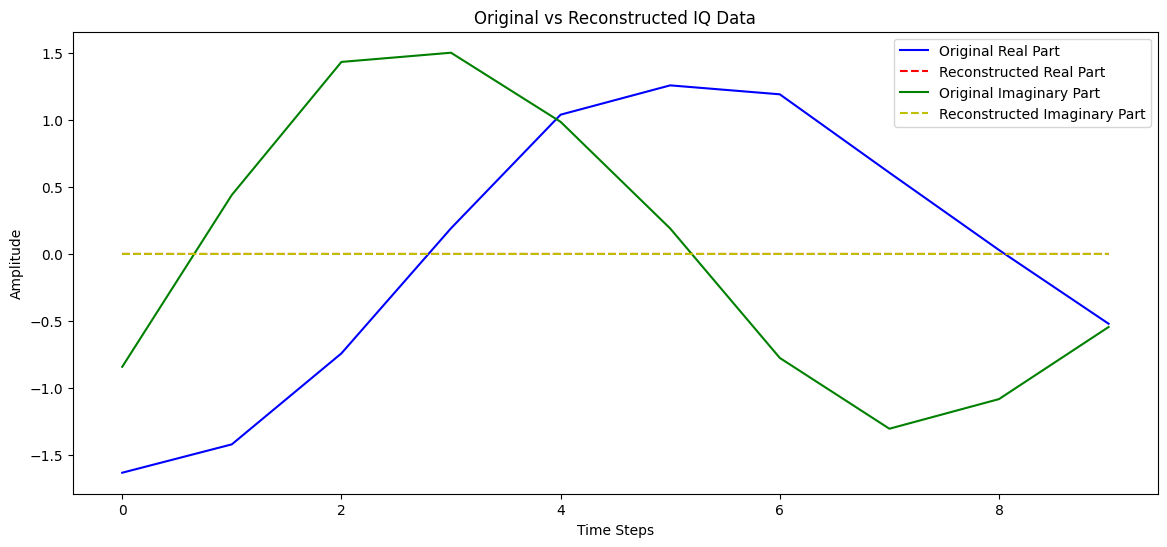

In [8]:
# Assuming X_chunk_test and X_chunk_pred are tensors on the GPU
# First, move the selected samples to CPU and convert to NumPy for plotting
sample_index = np.random.choice(len(X_chunk_test))
original_sample = X_chunk_test[sample_index].cpu().numpy()
reconstructed_sample = X_chunk_pred[sample_index].cpu().numpy()

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'y--', label='Reconstructed Imaginary Part')
plt.title('Original vs Reconstructed IQ Data')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


Shape of avg_real: (100,)
Shape of avg_imag: (100,)
Shape of last_errors: (100,)


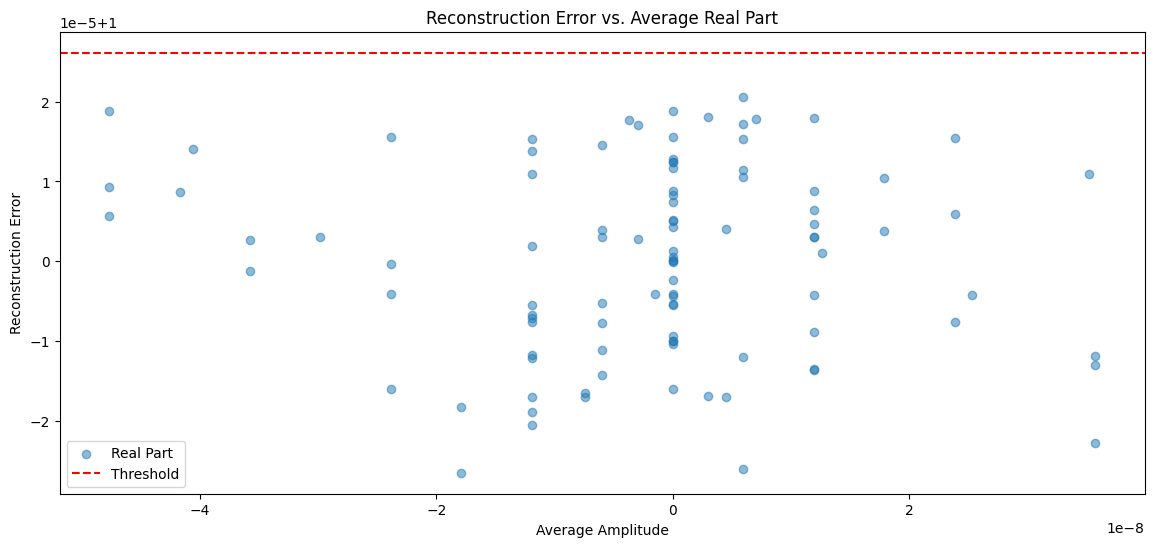

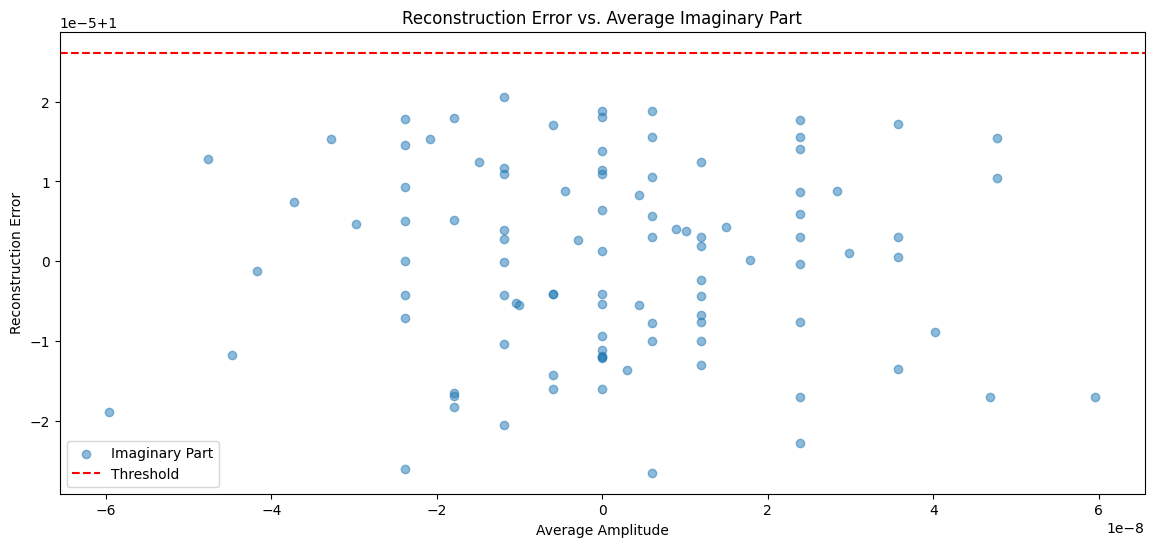

In [9]:
# Convert PyTorch tensors to NumPy arrays before calculating means
avg_real = np.mean(X_chunk_test.cpu().numpy(), axis=1)[:, 0]
avg_imag = np.mean(X_chunk_test.cpu().numpy(), axis=1)[:, 1]

# Assuming reconstruction_errors is a NumPy array or a list of errors
# If reconstruction_errors is a tensor, ensure to convert it with .cpu().numpy() as well
last_errors = np.mean(reconstruction_errors[-len(X_chunk_test):], axis=1)

print("Shape of avg_real:", avg_real.shape)
print("Shape of avg_imag:", avg_imag.shape)
print("Shape of last_errors:", last_errors.shape)

plt.figure(figsize=(14, 6))
plt.scatter(avg_real, last_errors, label='Real Part', alpha=0.5)
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error vs. Average Real Part')
plt.xlabel('Average Amplitude')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()

plt.figure(figsize=(14, 6))
plt.scatter(avg_imag, last_errors, label='Imaginary Part', alpha=0.5)
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error vs. Average Imaginary Part')
plt.xlabel('Average Amplitude')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()


In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `z_mean` and `z_log_var` are obtained from your model's encoder

# Function to sample using standard VAE sampling method
def sample_vae(z_mean, z_log_var):
    std = torch.exp(0.5 * z_log_var)
    eps = torch.randn_like(std)
    return z_mean + eps * std

# Function to sample using your MEC-based method (_sampling3)
def sample_mec(z_mean, device):
    # Example of processing z_mean with MEC. You will replace this with your actual _sampling3 function
    # This is a placeholder to illustrate the workflow
    z_mean_transformed = z_mean  # Placeholder for actual transformation
    eps = torch.randn_like(z_mean_transformed) * 0.1  # Example std deviation
    return z_mean_transformed + eps

# Assuming device is defined (e.g., "cuda" or "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_mean = z_mean.to(device)
z_log_var = z_log_var.to(device)

# Sampling
z_sampled_vae = sample_vae(z_mean, z_log_var)
z_sampled_mec = sample_mec(z_mean, device)

# Plotting functions
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def plot_distribution(tensor, label, color):
    # Ensure tensor is on CPU and flatten it for histogramming
    tensor = tensor.detach().cpu().numpy().flatten()
    
    # Histogram
    plt.hist(tensor, bins=30, density=True, alpha=0.6, label=label, color=color)
    
    # KDE plot
    kde = gaussian_kde(tensor)
    kde_x = np.linspace(tensor.min(), tensor.max(), 500)
    kde_y = kde.evaluate(kde_x)
    plt.plot(kde_x, kde_y, color=color, alpha=0.7)

# Visualization setup
plt.figure(figsize=(14, 6))

# Call the plotting function for z_mean and sampled distributions
plot_distribution(z_mean, "z_mean distribution", "blue")
plot_distribution(z_sampled_vae, "Sampled VAE z distribution", "red")
plot_distribution(z_sampled_mec, "Sampled MEC z distribution", "green")

plt.legend()
plt.title('Latent Variable Distributions Before and After Sampling')
plt.show()



NameError: name 'z_mean' is not defined

In [ ]:
import matplotlib.pyplot as plt

def scatter_plot(latent_variables, labels, title):
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(labels):
        plt.scatter(latent_variables[:, i, 0], latent_variables[:, i, 1], alpha=0.7, label=label)
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# Assuming z_mean is of shape (n_samples, n_latent_dims)
# And you have z_sampled_vae and z_sampled_mec with the same shape
# We'll take the first two dimensions for plotting
z_mean_2d = z_mean[:, :2].detach().cpu().numpy()  # Take first two dimensions for 2D scatter plot
z_sampled_vae_2d = z_sampled_vae[:, :2].detach().cpu().numpy()
z_sampled_mec_2d = z_sampled_mec[:, :2].detach().cpu().numpy()

# Combine them for plotting
latent_variables = np.stack([z_mean_2d, z_sampled_vae_2d, z_sampled_mec_2d], axis=1)
labels = ['z_mean', 'Sampled VAE', 'Sampled MEC']

scatter_plot(latent_variables, labels, 'Latent Space 2D Distribution')


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def scatter_plot(latent_variables, labels, title):
    plt.figure(figsize=(10, 8))
    
    # Define distinct colors for visibility: red for z_mean, orange for Sampled VAE, and limegreen for Sampled MEC
    colors = ['red', 'orange', 'limegreen']
    
    # Plot each set of points with the new colors
    for i, (label, color) in enumerate(zip(labels, colors)):
        plt.scatter(latent_variables[:, i, 0], latent_variables[:, i, 1], alpha=0.7, label=label, color=color)

    # Print the range of z_mean data points
    print(f"z_mean Latent Dimension 1 range: {latent_variables[:, 0, 0].min()} to {latent_variables[:, 0, 0].max()}")
    print(f"z_mean Latent Dimension 2 range: {latent_variables[:, 0, 1].min()} to {latent_variables[:, 0, 1].max()}")

    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title(title)

    # Set the x and y axes limits
    all_latent_vars = latent_variables.reshape(-1, latent_variables.shape[-1])
    x_min, x_max = all_latent_vars[:, 0].min(), all_latent_vars[:, 0].max()
    y_min, y_max = all_latent_vars[:, 1].min(), all_latent_vars[:, 1].max()
    plt.xlim(x_min - 1, x_max + 1)
    plt.ylim(y_min - 1, y_max + 1)

    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# Assuming z_mean, z_sampled_vae, and z_sampled_mec are already defined and have the correct shape

# Combine them for plotting
latent_variables = np.stack([z_mean_2d, z_sampled_vae_2d, z_sampled_mec_2d], axis=1)
labels = ['z_mean', 'Sampled VAE', 'Sampled MEC']

scatter_plot(latent_variables, labels, 'Latent Space 2D Distribution')


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def scatter_subplots(latent_variables, labels, title):
    # Set up a figure with three subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 8), sharey=True)
    
    # Define distinct colors for visibility
    colors = ['red', 'orange', 'limegreen']

    # Plot each set of points in its own subplot
    for i, (ax, label, color) in enumerate(zip(axs, labels, colors)):
        ax.scatter(latent_variables[:, i, 0], latent_variables[:, i, 1], alpha=0.7, color=color)
        ax.set_title(f"{label} Distribution")
        ax.grid(True)
        # Set the same x and y limits for all subplots based on overall data
        all_latent_vars = latent_variables.reshape(-1, latent_variables.shape[-1])
        x_min, x_max = all_latent_vars[:, 0].min(), all_latent_vars[:, 0].max()
        y_min, y_max = all_latent_vars[:, 1].min(), all_latent_vars[:, 1].max()
        ax.set_xlim(x_min - 1, x_max + 1)
        ax.set_ylim(y_min - 1, y_max + 1)

    # Set common labels
    fig.text(0.5, 0.04, 'Latent Dimension 1', ha='center')
    fig.text(0.04, 0.5, 'Latent Dimension 2', va='center', rotation='vertical')
    plt.suptitle(title)
    
    plt.show()

# Example usage:
# Assuming z_mean, z_sampled_vae, and z_sampled_mec are already defined and have the correct shape

# Combine them for plotting
latent_variables = np.stack([z_mean_2d, z_sampled_vae_2d, z_sampled_mec_2d], axis=1)
labels = ['z_mean', 'Sampled VAE', 'Sampled MEC']

scatter_subplots(latent_variables, labels, 'Separate Latent Space 2D Distributions')


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def scatter_dual_plots(latent_variables, labels, title):
    # Set up a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True)

    # Define distinct colors for visibility: red for z_mean, green for Sampled MEC, and orange for Sampled VAE
    colors = ['red', 'limegreen', 'orange']

    # Scatter plot for z_mean and Sampled MEC
    axs[0].scatter(latent_variables[:, 0, 0], latent_variables[:, 0, 1], alpha=0.7, color=colors[0], s=90, label=labels[0])
    axs[0].scatter(latent_variables[:, 2, 0], latent_variables[:, 2, 1], alpha=0.7, color=colors[2], s=90, label=labels[2])
    axs[0].set_title(f"{labels[0]} and {labels[2]} Distribution")
    axs[0].legend()
    axs[0].grid(True)

    # Scatter plot for z_mean and Sampled VAE
    axs[1].scatter(latent_variables[:, 0, 0], latent_variables[:, 0, 1], alpha=0.7, color=colors[0], s=90, label=labels[0])
    axs[1].scatter(latent_variables[:, 1, 0], latent_variables[:, 1, 1], alpha=0.7, color=colors[1], s=90, label=labels[1])
    axs[1].set_title(f"{labels[0]} and {labels[1]} Distribution")
    axs[1].legend()
    axs[1].grid(True)
    
    # Scatter plot for z_mean and Sampled VAE
#     axs[1].scatter(latent_variables[:, 1, 0], latent_variables[:, 1, 1], alpha=0.7, color=colors[0], s=90, label=labels[0])
#     axs[1].scatter(latent_variables[:, 2, 0], latent_variables[:, 2, 1], alpha=0.7, color=colors[1], s=90, label=labels[1])
#     axs[1].set_title(f"{labels[1]} and {labels[2]} Distribution")
#     axs[1].legend()
#     axs[1].grid(True)

    # Set the same x and y limits for all subplots based on overall data
    all_latent_vars = latent_variables.reshape(-1, latent_variables.shape[-1])
    x_min, x_max = all_latent_vars[:, 0].min(), all_latent_vars[:, 0].max()
    y_min, y_max = all_latent_vars[:, 1].min(), all_latent_vars[:, 1].max()
    for ax in axs:
        ax.set_xlim(x_min - 1, x_max + 1)
        ax.set_ylim(y_min - 1, y_max + 1)

    # Set common labels
    fig.text(0.5, 0.04, 'Latent Dimension 1', ha='center')
    fig.text(0.04, 0.5, 'Latent Dimension 2', va='center', rotation='vertical')
    plt.suptitle(title)
    
    plt.show()
def scatter_all_plots(latent_variables, labels, title):
    plt.figure(figsize=(10, 8))

    # Define distinct colors for visibility: red for z_mean, orange for Sampled VAE, and limegreen for Sampled MEC
    colors = ['red', 'orange', 'limegreen']

    # Plot each set of points with the new colors
    for i, (label, color) in enumerate(zip(labels, colors)):
        plt.scatter(latent_variables[:, i, 0], latent_variables[:, i, 1], alpha=0.7, color=color, s=100, label=label)

    # Set the x and y axes limits based on overall data
    all_latent_vars = latent_variables.reshape(-1, latent_variables.shape[-1])
    x_min, x_max = all_latent_vars[:, 0].min(), all_latent_vars[:, 0].max()
    y_min, y_max = all_latent_vars[:, 1].min(), all_latent_vars[:, 1].max()
    plt.xlim(x_min - 1, x_max + 1)
    plt.ylim(y_min - 1, y_max + 1)

    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()
def scatter_vae_mec(latent_variables, labels, title):
    plt.figure(figsize=(10, 8))

    # Define colors for visibility: orange for Sampled VAE and limegreen for Sampled MEC
    colors = ['orange', 'limegreen']

    # Plot each set of points with the colors
    plt.scatter(latent_variables[:, 1, 0], latent_variables[:, 1, 1], alpha=0.7, color=colors[0], s=80, label=labels[1])
    plt.scatter(latent_variables[:, 2, 0], latent_variables[:, 2, 1], alpha=0.7, color=colors[1], s=80, label=labels[2])

    # Set the x and y axes limits based on the plotted data
    vae_mec_latent_vars = np.concatenate((latent_variables[:, 1], latent_variables[:, 2]), axis=0)
    x_min, x_max = vae_mec_latent_vars[:, 0].min(), vae_mec_latent_vars[:, 0].max()
    y_min, y_max = vae_mec_latent_vars[:, 1].min(), vae_mec_latent_vars[:, 1].max()
    plt.xlim(x_min - 1, x_max + 1)
    plt.ylim(y_min - 1, y_max + 1)

    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()
# Example usage:
# Assuming z_mean, z_sampled_vae, and z_sampled_mec are already defined and have the correct shape

# Combine them for plotting
latent_variables = np.stack([z_mean_2d, z_sampled_vae_2d, z_sampled_mec_2d], axis=1)
labels = ['z_mean', 'Sampled VAE', 'Sampled MEC']

scatter_dual_plots(latent_variables, labels, 'Latent Space 2D Distributions')
scatter_all_plots(latent_variables, labels, 'Combined Latent Space 2D Distribution')
scatter_vae_mec(latent_variables, labels, 'Sampled VAE vs Sampled MEC Latent Space 2D Distribution')

In [ ]:
import seaborn as sns
import pandas as pd

# We'll assume z_mean, z_sampled_vae, and z_sampled_mec are tensors with at least 2 dimensions.
# Convert PyTorch tensors to numpy arrays and then to a pandas DataFrame for Seaborn.
z_mean_np = z_mean[:, :2].detach().cpu().numpy()  # Replace with your actual data
z_sampled_vae_np = z_sampled_vae[:, :2].detach().cpu().numpy()  # Replace with your actual data
z_sampled_mec_np = z_sampled_mec[:, :2].detach().cpu().numpy()  # Replace with your actual data

# Create a DataFrame
df = pd.DataFrame({
    'Latent Dimension 1': np.concatenate([z_mean_np[:, 0], z_sampled_vae_np[:, 0], z_sampled_mec_np[:, 0]]),
    'Latent Dimension 2': np.concatenate([z_mean_np[:, 1], z_sampled_vae_np[:, 1], z_sampled_mec_np[:, 1]]),
    'Type': ['z_mean'] * len(z_mean_np) + ['Sampled VAE'] * len(z_sampled_vae_np) + ['Sampled MEC'] * len(z_sampled_mec_np)
})

# Use Seaborn to plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='Latent Dimension 1', y='Latent Dimension 2', hue='Type', alpha=0.7)
plt.title('Latent Space 2D Distribution with Seaborn')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def enhanced_scatter_plot(dataframe, hue, figsize=(12, 9), marker_size=150, 
                          context='talk', style='whitegrid', palette='colorblind',
                          title='Enhanced Latent Space 2D Distribution with Seaborn'):
    # Set the aesthetics
    sns.set(style=style, context=context, palette=palette)

    # Create the plot
    plt.figure(figsize=figsize)
    scatter = sns.scatterplot(data=dataframe, x='Latent Dimension 1', y='Latent Dimension 2', 
                              hue=hue, s=marker_size, alpha=0.8)

    # Enhance the legend
    plt.legend(title=hue, title_fontsize='13', fontsize='12', loc='upper left', bbox_to_anchor=(1, 1))

    # Set labels and title with a larger font size
    plt.xlabel('Latent Dimension 1', fontsize=15)
    plt.ylabel('Latent Dimension 2', fontsize=15)
    plt.title(title, fontsize=18)

    # Despine the top and right spines of the plot
    sns.despine(trim=True)

    # Finally, show the plot
    plt.show()

# Assuming z_mean, z_sampled_vae, and z_sampled_mec are already defined and have the correct shape
z_mean_np = z_mean[:, :2].detach().cpu().numpy()
z_sampled_vae_np = z_sampled_vae[:, :2].detach().cpu().numpy()
z_sampled_mec_np = z_sampled_mec[:, :2].detach().cpu().numpy()

# Create a DataFrame
df = pd.DataFrame({
    'Latent Dimension 1': np.concatenate([z_mean_np[:, 0], z_sampled_vae_np[:, 0], z_sampled_mec_np[:, 0]]),
    'Latent Dimension 2': np.concatenate([z_mean_np[:, 1], z_sampled_vae_np[:, 1], z_sampled_mec_np[:, 1]]),
    'Type': ['z_mean'] * len(z_mean_np) + ['Sampled VAE'] * len(z_sampled_vae_np) + ['Sampled MEC'] * len(z_sampled_mec_np),
    'Size': [120] * len(z_mean_np) + [100] * len(z_sampled_vae_np) + [200] * len(z_sampled_mec_np)
})

# Define a custom color palette
custom_colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

# Call the function with the custom color palette
enhanced_scatter_plot(df, hue='Type', palette=custom_colors)


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def enhanced_scatter_plot(dataframe, hue, figsize=(12, 9), marker_sizes_dict=None,
                          context='talk', style='whitegrid', palette='colorblind',
                          title='Enhanced Latent Space 2D Distribution with Seaborn',
                          extend_axis_factor=2):
    # Set the aesthetics
    sns.set(style=style, context=context, palette=palette)

    # Create the plot
    plt.figure(figsize=figsize)
    
    # Define default marker size if not provided
    default_marker_size = 150

    # Plot each category with its specified or default marker size
    if marker_sizes_dict:
        for category, msize in marker_sizes_dict.items():
            subset = dataframe[dataframe[hue] == category]
            sns.scatterplot(data=subset, x='Latent Dimension 1', y='Latent Dimension 2', 
                            hue=hue, s=msize, alpha=0.8, legend=False)
    else:
        sns.scatterplot(data=dataframe, x='Latent Dimension 1', y='Latent Dimension 2', 
                        hue=hue, s=default_marker_size, alpha=0.8)

    # Get current axis limits
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()

    # Extend the x and y axes
    plt.xlim(x_min * extend_axis_factor, x_max * extend_axis_factor)
    plt.ylim(y_min * extend_axis_factor, y_max * extend_axis_factor)

    # Enhance the legend
    plt.legend(title=hue, title_fontsize='13', fontsize='12', loc='upper left', bbox_to_anchor=(1, 1))

    # Set labels and title with a larger font size
    plt.xlabel('Latent Dimension 1', fontsize=15)
    plt.ylabel('Latent Dimension 2', fontsize=15)
    plt.title(title, fontsize=18)

    # Despine the top and right spines of the plot
    sns.despine(trim=True)

    # Finally, show the plot
    plt.show()

# Assuming z_mean, z_sampled_vae, and z_sampled_mec are already defined and have the correct shape

# Create a DataFrame
df = pd.DataFrame({
    'Latent Dimension 1': np.concatenate([z_mean_np[:, 0], z_sampled_vae_np[:, 0], z_sampled_mec_np[:, 0]]),
    'Latent Dimension 2': np.concatenate([z_mean_np[:, 1], z_sampled_vae_np[:, 1], z_sampled_mec_np[:, 1]]),
    'Type': ['z_mean'] * len(z_mean_np) + ['Sampled VAE'] * len(z_sampled_vae_np) + ['Sampled MEC'] * len(z_sampled_mec_np)
})

# Define a custom color palette
custom_colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

# Define custom marker sizes for each category
custom_marker_sizes = {
    'z_mean': 200,        # Bigger marker size for z_mean
    'Sampled VAE': 150,   # Bigger marker size for Sampled VAE
    'Sampled MEC': 100    # Bigger marker size for Sampled MEC
}

# Call the function with the custom color palette and custom marker sizes
enhanced_scatter_plot(df, hue='Type', palette=custom_colors, marker_sizes_dict=custom_marker_sizes, extend_axis_factor=2)


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def enhanced_scatter_plot(dataframe, hue, figsize=(14, 8), marker_sizes_dict=None,
                          context='talk', style='whitegrid', palette=None,
                          title='Enhanced Latent Space 2D Distribution with Seaborn',
                          extend_axis_factor=2):
    # Set the aesthetics
    sns.set(style=style, context=context)

    # Create the plot
    plt.figure(figsize=figsize)
    
    # Define default marker size if not provided
    default_marker_size = 150

    # Check if a custom palette is provided, otherwise use Seaborn's default
    if palette is None:
        palette = sns.color_palette("husl", len(dataframe[hue].unique()))

    # Plot each category with its specified or default marker size
    if marker_sizes_dict:
        for category, msize in marker_sizes_dict.items():
            subset = dataframe[dataframe[hue] == category]
            sns.scatterplot(data=subset, x='Latent Dimension 1', y='Latent Dimension 2', 
                            hue=hue, s=msize, alpha=0.8, palette=palette, legend='full')
    else:
        sns.scatterplot(data=dataframe, x='Latent Dimension 1', y='Latent Dimension 2', 
                        hue=hue, s=default_marker_size, alpha=0.8, palette=palette, legend='full')

    # Get current axis limits
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()

    # Extend the x and y axes
    plt.xlim(x_min * extend_axis_factor, x_max * extend_axis_factor)
    plt.ylim(y_min * extend_axis_factor, y_max * extend_axis_factor)

    # Set labels and title with a larger font size
    plt.xlabel('Latent Dimension 1', fontsize=15)
    plt.ylabel('Latent Dimension 2', fontsize=15)
    plt.title(title, fontsize=18)

    # Place the legend outside the plot
    plt.legend(title=hue, title_fontsize='13', fontsize='12', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Despine the top and right spines of the plot
    sns.despine(trim=True)

    # Finally, show the plot
    plt.show()

# Create a DataFrame
df = pd.DataFrame({
    'Latent Dimension 1': np.concatenate([z_mean_np[:, 0], z_sampled_vae_np[:, 0], z_sampled_mec_np[:, 0]]),
    'Latent Dimension 2': np.concatenate([z_mean_np[:, 1], z_sampled_vae_np[:, 1], z_sampled_mec_np[:, 1]]),
    'Type': ['z_mean'] * len(z_mean_np) + ['Sampled VAE'] * len(z_sampled_vae_np) + ['Sampled MEC'] * len(z_sampled_mec_np)
})

# Define a custom color palette
custom_colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]


# Example usage:
# Define custom marker sizes for each category
custom_marker_sizes = {
    'z_mean': 300,        # Bigger marker size for z_mean
    'Sampled VAE': 200,   # Bigger marker size for Sampled VAE
    'Sampled MEC': 200    # Bigger marker size for Sampled MEC
}

# Define a custom color palette
custom_palette = {
    'z_mean': "#e74c3c",  # Red color for z_mean
    'Sampled VAE': "#3498db",  # Blue color for Sampled VAE
    'Sampled MEC': "#2ecc71"   # Green color for Sampled MEC
}

# Call the function with the custom color palette and custom marker sizes
enhanced_scatter_plot(df, hue='Type', palette=custom_palette, marker_sizes_dict=custom_marker_sizes, extend_axis_factor=2)


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def enhanced_scatter_plot(dataframe, hue, figsize=(12, 9), 
                          marker_sizes=None, context='talk', 
                          style='whitegrid', palette='colorblind',
                          title='Enhanced Latent Space 2D Distribution with Seaborn'):
    # Set the aesthetics
    sns.set(style=style, context=context, palette=palette)

    # Create the plot
    plt.figure(figsize=figsize)
    
    # If marker_sizes is not specified, default to 100 for all
    if not marker_sizes:
        marker_sizes = {category: 100 for category in dataframe[hue].unique()}
    
    # Plot each category with its own marker size
    unique_categories = dataframe[hue].unique()
    for category in unique_categories:
        subset = dataframe[dataframe[hue] == category]
        sns.scatterplot(data=subset, x='Latent Dimension 1', y='Latent Dimension 2', 
                        label=category, s=marker_sizes[category], alpha=0.8)

    # Enhance the legend
    plt.legend(title=hue, title_fontsize='13', fontsize='12')

    # Set labels and title with a larger font size
    plt.xlabel('Latent Dimension 1', fontsize=15)
    plt.ylabel('Latent Dimension 2', fontsize=15)
    plt.title(title, fontsize=18)

    # Despine the top and right spines of the plot
    sns.despine(trim=True)

    # Finally, show the plot
    plt.show()

# Example usage:
# Define marker sizes for each category
marker_sizes = {
    'z_mean': 150,
    'Sampled VAE': 100,
    'Sampled MEC': 150
}

# Call the function with custom marker sizes
enhanced_scatter_plot(df, hue='Type', marker_sizes=marker_sizes)


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming z_mean, z_sampled_vae, and z_sampled_mec are already defined and converted to numpy arrays

# Create a DataFrame
df = pd.DataFrame({
    'Latent Dimension 1': np.concatenate([z_mean_np[:, 0], z_sampled_vae_np[:, 0], z_sampled_mec_np[:, 0]]),
    'Latent Dimension 2': np.concatenate([z_mean_np[:, 1], z_sampled_vae_np[:, 1], z_sampled_mec_np[:, 1]]),
    'Type': ['z_mean'] * len(z_mean_np) + ['Sampled VAE'] * len(z_sampled_vae_np) + ['Sampled MEC'] * len(z_sampled_mec_np),
    'Size': [120] * len(z_mean_np) + [100] * len(z_sampled_vae_np) + [120] * len(z_sampled_mec_np)
})

# Set the aesthetic style of the plots
sns.set(style="whitegrid", context="talk", palette="colorblind")

# Create a FacetGrid object to control the size of each point individually
g = sns.FacetGrid(df, hue="Type", height=6, aspect=1.5, legend_out=True)

# Use the 'Size' column to set the size of each point
g = g.map(plt.scatter, "Latent Dimension 1", "Latent Dimension 2", "Size", edgecolor="w", alpha=0.7)

# Adjust the axis limits to add some padding around the points
padding = 0.2
x_min, x_max = df['Latent Dimension 1'].min(), df['Latent Dimension 1'].max()
y_min, y_max = df['Latent Dimension 2'].min(), df['Latent Dimension 2'].max()
plt.xlim(x_min - (x_max - x_min) * padding, x_max + (x_max - x_min) * padding)
plt.ylim(y_min - (y_max - y_min) * padding, y_max + (y_max - y_min) * padding)

# Add the legend and titles
g.add_legend(title="Type")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Latent Space 2D Distribution with Seaborn')
plt.show()


In [ ]:
eps = np.random.normal(size=z_mean.shape)
z_sampled = z_mean + np.exp(0.5 * z_log_var) * eps

# Plotting
plt.figure(figsize=(12, 6))

# Plot z_mean distribution
sns.histplot(z_mean.detach().numpy().flatten(), color="blue", kde=True, stat="density", label="z_mean distribution")

# Plot sampled z distribution
sns.histplot(z_sampled.detach().numpy().flatten(), color="red", kde=True, stat="density", alpha=0.6, label="Sampled z distribution")

plt.legend()
plt.title('Latent Variable Distributions')
plt.show()

In [ ]:
# reconstruction error
reconstruction_error_real = reconstruction_error[:, 0]
reconstruction_error_imag = reconstruction_error[:, 1]

# Plot for Real Part
plt.figure(figsize=(14, 6))
mellow_green = '#89C997' 
plt.plot(reconstruction_error_real, label='Reconstruction Error', color=mellow_green)
plt.axhline(y=threshold2, color='r', linestyle='--', label='Threshold')
plt.title('Intrusion Detected by Reconstruction Error',fontsize=16, fontweight='bold')
plt.xlabel('Sequence Number (×10³)', fontsize=16, fontweight='bold')
#plt.xlabel('Sequence Number(*1000)', fontsize=16, fontweight='bold')
plt.ylabel('Reconstruction Error', fontsize=16, fontweight='bold')
for label in (plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
    label.set_fontsize(12)
    label.set_fontweight('bold')
plt.legend(fontsize=15)
plt.show()

In [ ]:
sample_index = np.random.choice(len(X_chunk_test))
original_sample = X_chunk_test[sample_index]
reconstructed_sample = X_chunk_pred[sample_index]

plt.figure(figsize=(16, 8))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'b--', label='Reconstructed Real Part')
# plt.plot(original_sample[:, 1], 'm-', label='Original Real STD')
# plt.plot(reconstructed_sample[:, 1], 'm--', label='Reconstructed Real STD')
# plt.plot(original_sample[:, 2], 'c-', label='Original Real Skew')
# plt.plot(reconstructed_sample[:, 2], 'c--', label='Reconstructed Real Skew')
# plt.plot(original_sample[:, 3], 'orange', label='Original Real Kurtosis')
# plt.plot(reconstructed_sample[:, 3], 'orange', label='Reconstructed Real Kurtosis', linestyle='--')

plt.plot(original_sample[:, 1], 'g-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 1], 'g--', label='Reconstructed Imaginary Part')
# plt.plot(original_sample[:, 5], 'purple', label='Original Imaginary STD')
# plt.plot(reconstructed_sample[:, 5], 'purple', label='Reconstructed Imaginary STD', linestyle='--')
# plt.plot(original_sample[:, 6], 'brown', label='Original Imaginary Skew')
# plt.plot(reconstructed_sample[:, 6], 'brown', label='Reconstructed Imaginary Skew', linestyle='--')
# plt.plot(original_sample[:, 7], 'pink', label='Original Imaginary Kurtosis')
# plt.plot(reconstructed_sample[:, 7], 'pink', label='Reconstructed Imaginary Kurtosis', linestyle='--')
plt.title('Original vs Reconstructed IQ Data')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')

# Place the legend outside the plot area
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', title='Legend')

# Adjust layout to make room for the legend
plt.tight_layout()

plt.show()

In [ ]:
reconstruction_error_real_parts = reconstruction_error[:, 0]
reconstruction_error_real_std = reconstruction_error[:, 1]
reconstruction_error_real_skew = reconstruction_error[:, 2]
reconstruction_error_real_kurtosis = reconstruction_error[:, 3]
reconstruction_error_imag_parts = reconstruction_error[:, 4]
reconstruction_error_imag_std = reconstruction_error[:, 5]
reconstruction_error_imag_skew = reconstruction_error[:, 6]
reconstruction_error_imag_kurtosis = reconstruction_error[:, 7]


In [ ]:
sample_index = np.random.choice(len(X_chunk_test))
original_sample = X_chunk_test[sample_index]
reconstructed_sample = X_chunk_pred[sample_index]

plt.figure(figsize=(16, 8))
# plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
# plt.plot(reconstructed_sample[:, 0], 'b--', label='Reconstructed Real Part')
# plt.plot(original_sample[:, 1], 'm-', label='Original Real STD')
# plt.plot(reconstructed_sample[:, 1], 'm--', label='Reconstructed Real STD')
plt.plot(original_sample[:, 2], 'c-', label='Original Real Skew')
plt.plot(reconstructed_sample[:, 2], 'c--', label='Reconstructed Real Skew')
plt.plot(original_sample[:, 3], 'orange', label='Original Real Kurtosis')
plt.plot(reconstructed_sample[:, 3], 'orange', label='Reconstructed Real Kurtosis', linestyle='--')

# plt.plot(original_sample[:, 4], 'g-', label='Original Imaginary Part')
# plt.plot(reconstructed_sample[:, 4], 'g--', label='Reconstructed Imaginary Part')
# plt.plot(original_sample[:, 5], 'purple', label='Original Imaginary STD')
# plt.plot(reconstructed_sample[:, 5], 'purple', label='Reconstructed Imaginary STD', linestyle='--')
plt.plot(original_sample[:, 6], 'brown', label='Original Imaginary Skew')
plt.plot(reconstructed_sample[:, 6], 'brown', label='Reconstructed Imaginary Skew', linestyle='--')
plt.plot(original_sample[:, 7], 'pink', label='Original Imaginary Kurtosis')
plt.plot(reconstructed_sample[:, 7], 'pink', label='Reconstructed Imaginary Kurtosis', linestyle='--')
plt.title('Original vs Reconstructed IQ Data')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')

# Place the legend outside the plot area
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', title='Legend')

# Adjust layout to make room for the legend
plt.tight_layout()

plt.show()

In [ ]:
# # Define the number of sequences to plot together
n = 2  # Change this to desired number of sequences
sample_length = sequence_length * n

# Select a random starting sequence for plotting
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)

# Extract and concatenate the original and reconstructed samples
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

# Plot concatenated sequences
plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 0], 'b-', label='Original Real Part')
plt.plot(reconstructed_sample[:, 0], 'r--', label='Reconstructed Real Part')
plt.plot(original_sample[:, 1], 'orange', label='Original Real STD')
plt.plot(reconstructed_sample[:, 1], 'orange', label='Reconstructed Real STD', linestyle='--')

plt.plot(original_sample[:, 4], 'y-', label='Original Imaginary Part')
plt.plot(reconstructed_sample[:, 4], 'g--', label='Reconstructed Imaginary Part')
plt.plot(original_sample[:, 5], 'pink', label='Original Imaginary STD')
plt.plot(reconstructed_sample[:, 5], 'pink', label='Reconstructed Imaginary STD', linestyle='--')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('9-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

In [ ]:
# Repeat for n = 9
n = 4  # Change this to desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 2], 'b-', label='Original Real Part Skew')
plt.plot(reconstructed_sample[:, 2], 'r--', label='Reconstructed Real Part Skew')
plt.plot(original_sample[:, 6], 'g-', label='Original Imaginary Part Skew')
plt.plot(reconstructed_sample[:, 6], 'y--', label='Reconstructed Imaginary Part Skew')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('11-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()

In [ ]:
# Repeat for n = 9
n = 4  # Change this to desired number of sequences
sequence_index = np.random.choice(len(X_chunk_test) - n + 1)
original_sample = np.concatenate(X_chunk_test[sequence_index:sequence_index + n])
reconstructed_sample = np.concatenate(X_chunk_pred[sequence_index:sequence_index + n])

plt.figure(figsize=(14, 6))
plt.plot(original_sample[:, 3], 'b-', label='Original Real Part Kurtosis')
plt.plot(reconstructed_sample[:, 3], 'r--', label='Reconstructed Real Part Kurtosis')
plt.plot(original_sample[:, 7], 'g-', label='Original Imaginary Part Kurtosis')
plt.plot(reconstructed_sample[:, 7], 'y--', label='Reconstructed Imaginary Part Kurtosis')
plt.title(f'Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
# plt.savefig('11-Original vs Reconstructed IQ Data for {n} Sequences of Length {sequence_length}.png')
# plt.close()
plt.show()